In [21]:
import numpy as np

!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz
!ls -l

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

x_train = np.zeros((0,3072))
y_train = np.array([])
for i in range(1,6):
  raw = unpickle(f"/content/cifar-10-batches-py/data_batch_{i}")
  x_train = np.append(x_train,np.array(raw[b'data']),axis=0)
  y_train = np.append(y_train,np.array(raw[b'labels']),axis=0)

test = unpickle("/content/cifar-10-batches-py/test_batch")
x_test = np.array(test[b'data'])
y_test = np.array(test[b'labels'])

meta = unpickle("/content/cifar-10-batches-py/batches.meta")
labels= meta[b'label_names']

--2020-11-17 15:21:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  31.2MB/s    in 5.8s    

2020-11-17 15:21:21 (27.8 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]

total 499524
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz.1
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz.2
drwxr-xr-x 1 root root      4096 Nov 13 17:33 sample_data


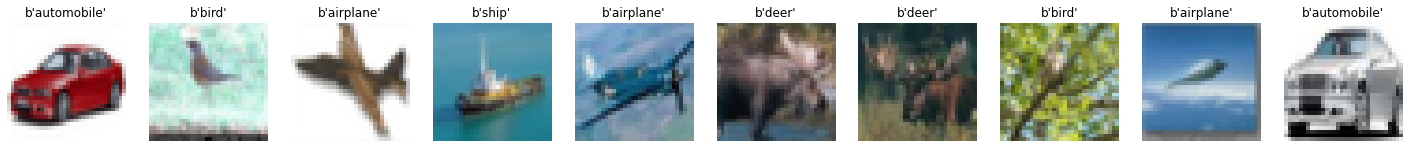

In [22]:
import matplotlib.pyplot as plt
import random

def to_img(arr):
    img = arr.reshape(3,32,32).transpose(1,2,0).astype(int)
    return img


plt.rcParams["figure.figsize"] = (25,10)
image_to_display = 10
j = 1
for i in random.sample(range(0, len(x_train)), image_to_display):
  plt.subplot(1, image_to_display,j)
  plt.imshow(to_img(x_train[i]))
  plt.axis('off')
  plt.title(labels[int(y_train[i])])
  j += 1 

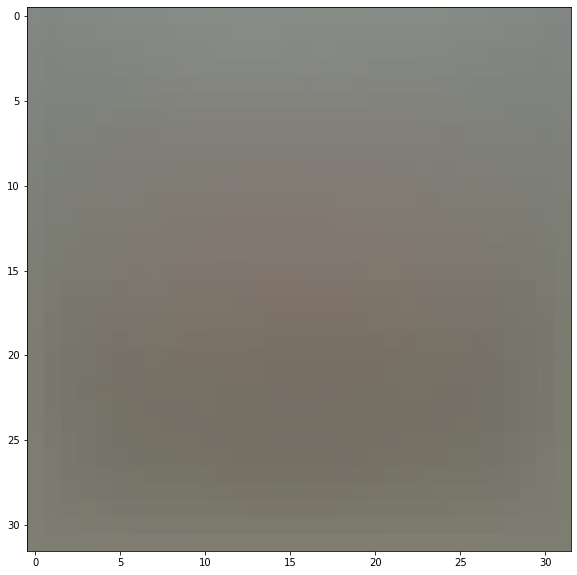

In [24]:
# preprocess input data (optionally)

def get_distribution(pixel):
  vals = [img[pixel] for img in x_train] + [img[pixel] for img in x_test]
  return np.array(vals)


pixel_std = np.array([get_distribution(pixel).std() for pixel in range(x_train.shape[1])])
mean_img = np.array([get_distribution(pixel).mean() for pixel in range(x_train.shape[1])])

plt.imshow(to_img(mean_img))


In [26]:
x_train = np.divide(np.subtract(x_train, mean_img), pixel_std)
x_test = np.divide(np.subtract(x_test, mean_img), pixel_std)

In [31]:
# Implement LinearClassifier class for CIFAR10

class LinearClassifier:
  def __init__(self, labels):
    self.labels = labels
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    self.W = np.random.randn(3073, self.classes_num) * 0.0001
    self.batch_size = 32

  def train(self, x_train, y_train, learning_rate = 1e-7):
    # Split dataset into batches
    num_batches = x_train.shape[0] // self.batch_size

    # adding b-coefficient column
    ones = np.eye(x_train.shape[0], 1)
    x_train = np.append(x_train, ones, axis=1)

    loss = 0
    for i in range(num_batches):
      x_batch = x_train[self.batch_size * i : self.batch_size * (i + 1)]
      y_batch = y_train[self.batch_size * i : self.batch_size * (i + 1)]
      # select_rnd = np.random.choice(x_train.shape[0], self.batch_size, replace=False)
      # x_batch = x_train[select_rnd]
      # y_batch = y_train[select_rnd]
      # calculate loss and grad over batch
      loss, dW = self.loss(x_batch, y_batch)
      # Update weights (self.W)
      self.W -= learning_rate * dW
    return loss

  def loss(self, x, y, reg=1e-6):
    # Calculate Multiclass SVM or Cross-entropy loss over a batch 
    dW = np.zeros(self.W.shape)
    loss = 0.0
    num_classes = self.W.shape[1]
    num_train = x.shape[0]

    for i in range(num_train):
      scores = x[i].dot(self.W)
      correct_class_score = scores[int(y[i])]
      above_zero = 0

      for j in range(num_classes):
        if j == int(y[i]):
          continue

        marg = scores[j] - correct_class_score + 1

        if marg > 0:
          above_zero += 1
          loss += marg
          dW[:, j] += x[i]

        dW[:, int(y[i])] -= above_zero * x[i]
        loss /= num_train

    loss += reg * np.sum(self.W * self.W)
    dW = dW / num_train + 2 * reg * self.W

    return loss, dW
      
  def predict(self,x):
    x_with_b = np.append(x, 1)
    scores = x_with_b.dot(self.W)
    return np.argmax(scores)
  


In [32]:
def validate(model,x_test,y_test):
  correct = 0
  for i,img in enumerate(x_test):
    index = model.predict(img)    
    correct += 1 if index == y_test[i] else 0
    if i > 0 and i % 1000 == 0:
      print ("Accuracy {:.3f}".format(correct/i))
      #return
      
      pass
  return correct/len(y_test)  

model = LinearClassifier(labels)
for epoch in range(15):
  loss = model.train(x_train,y_train)
  print(f"Epoch {epoch} Loss {loss}")
print(validate(model,x_test,y_test))

Epoch 0 Loss 0.022171706616971643
Epoch 1 Loss 0.013298122070406029
Epoch 2 Loss 0.006723706925018456
Epoch 3 Loss 0.0016542213667030874
Epoch 4 Loss 2.986465201350224e-05
Epoch 5 Loss 2.9681105940193452e-05
Epoch 6 Loss 2.9533173723506165e-05
Epoch 7 Loss 2.9436755131026926e-05
Epoch 8 Loss 2.9387816246989468e-05
Epoch 9 Loss 2.9377661345321267e-05
Epoch 10 Loss 2.9397214440788653e-05
Epoch 11 Loss 2.9457733556868416e-05
Epoch 12 Loss 2.954842192586635e-05
Epoch 13 Loss 2.9660784883575072e-05
Epoch 14 Loss 2.9784876050781422e-05
Accuracy 0.315
Accuracy 0.314
Accuracy 0.318
Accuracy 0.318
Accuracy 0.316
Accuracy 0.313
Accuracy 0.315
Accuracy 0.314
Accuracy 0.314
0.3145
